# Scalable E-Commerce Analytics & Customer Segmentation with PySpark

**Author:** Anita Okojie

## Overview
This project demonstrates a Big Data analytics pipeline using **Apache Spark (PySpark)** to analyze e-commerce behavior, calculate product profitability, and segment customers using Machine Learning.

**Business Goal:** Transform raw transactional logs into actionable insights for inventory management and targeted marketing.

## Key Features
*   **Big Data ETL:** Handles data ingestion, schema enforcement, and type casting for large datasets (Order Items, Products, Events).
*   **Relational Joins:** Performs complex SQL-style joins to link User demographics with Transactional history.
*   **Profitability Analysis:** Calculates real-time margins across product categories to identify high-value inventory.
*   **ML Customer Segmentation:** Uses **Spark MLlib (K-Means)** to group customers based on spending behavior (Frequency & Monetary value).

## Tech Stack
*   **Core Engine:** Apache Spark 3.5 (PySpark)
*   **Machine Learning:** PySpark MLlib (VectorAssembler, KMeans)
*   **Visualization:** Matplotlib & Seaborn (aggregated data only)
*   **Environment:** Local Standalone Cluster

---
*Note: This notebook is configured to run in a local Windows environment but is designed to scale to cloud clusters (Databricks/AWS EMR) with minimal changes and it requires a Kaggle API token to download the dataset programmatically.*

## 1. Dependency Management

In [2]:
%%capture
# Install required packages
!pip install pyspark matplotlib seaborn pandas kagglehub

## 2. Spark Initialization & Data Ingestion (ETL)

In [3]:
import sys
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType, TimestampType
from pyspark.sql.functions import col, when, isnan, to_date, lit, round, to_timestamp, regexp_replace, count, sum, avg, desc
from datetime import datetime
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def save_plot(fig, filename):
    try:
        
        import os
        if not os.path.exists('results'):
            os.makedirs('results')
        fig.savefig(f'results/{filename}')
        print(f"Saved visualization to results/{filename}")
    except:
        print("Could not save file, showing plot only")
        

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) 

# ========== SPARK CONFIG (Windows) ==========
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

print("Configuring Spark for Windows stability...")
spark = SparkSession.builder \
    .appName("Ecommerce Analysis") \
    .master("local[*]") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

print(f"Spark version: {spark.version}")

# Download dataset from Kaggle
print("Downloading dataset from Kaggle...")
try:
    dataset_path = kagglehub.dataset_download("mustafakeser4/looker-ecommerce-bigquery-dataset")
    print(f"Dataset downloaded to: {dataset_path}")
except Exception as e:
    print(f"Error downloading data: {e}")
    

file_paths = {
    'users': os.path.join(dataset_path, 'users.csv'),
    'inventory_items': os.path.join(dataset_path, 'inventory_items.csv'),
    'order_items': os.path.join(dataset_path, 'order_items.csv'),
    'orders': os.path.join(dataset_path, 'orders.csv'),
    'products': os.path.join(dataset_path, 'products.csv'),
    'events': os.path.join(dataset_path, 'events.csv'),
    'distribution_centers': os.path.join(dataset_path, 'distribution_centers.csv')
}

dataframes = {}

# Load CSV files into Spark DataFrames
def clean_and_load(name, path):
    try:
        print(f"Loading {name}...")
        df = spark.read.csv(path, header=True, inferSchema=True)
        
        # 1. Fix Timestamps 
        time_cols = []
        if name == 'order_items': time_cols = ['created_at', 'delivered_at', 'returned_at']
        elif name == 'inventory_items': time_cols = ['created_at', 'sold_at']
        elif name == 'orders': time_cols = ['created_at', 'returned_at', 'shipped_at', 'delivered_at']
        elif name == 'users': time_cols = ['created_at']
        elif name == 'events': time_cols = ['created_at']
            
        for t_col in time_cols:
            if t_col in df.columns:
                
                df = df.withColumn(t_col, regexp_replace(col(t_col), "\\+.*$", "").cast("timestamp"))

        # 2. Fix Numerics
        if name == 'users':
            df = df.withColumn('age', col('age').cast(IntegerType()))
        elif name == 'order_items':
            df = df.withColumn('sale_price', col('sale_price').cast(DoubleType()))
        elif name == 'inventory_items':
            df = df.withColumn('cost', col('cost').cast(DoubleType()))
            df = df.withColumn('product_retail_price', col('product_retail_price').cast(DoubleType()))
        elif name == 'products':
            df = df.withColumn('cost', col('cost').cast(DoubleType()))
            df = df.withColumn('retail_price', col('retail_price').cast(DoubleType()))

        print(f"✅ Loaded {name}: {df.count()} rows")
        return df
    except Exception as e:
        print(f"❌ Error loading {name}: {e}")
        return None

# Load all files
for name, path in file_paths.items():
    df = clean_and_load(name, path)
    if df is not None:
        dataframes[name] = df

# Quick data quality check
print(f"Schema for {name}:")
df.printSchema()

print("Data loading complete.")

# --- 4. ANALYSIS FUNCTION ---
def analyze_dataframe(df, name):
    print(f"\n=== Analysis of {name} ===")
    print(f"Total records: {df.count()}")
    
            
    # Show stats for numeric columns
    numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType))]
    if numeric_cols:
        # Limit to first 3 numeric columns to prevent memory overload
        df.select(numeric_cols[:3]).describe().show()

Configuring Spark for Windows stability...
Spark version: 3.5.5
Dataset downloaded to: C:\Users\Anita\.cache\kagglehub\datasets\mustafakeser4\looker-ecommerce-bigquery-dataset\versions\1
Loading users...
✅ Loaded users: 100000 rows
Loading inventory_items...
✅ Loaded inventory_items: 490705 rows
Loading order_items...
✅ Loaded order_items: 181759 rows
Loading orders...
✅ Loaded orders: 125226 rows
Loading products...
✅ Loaded products: 29120 rows
Loading events...
✅ Loaded events: 2431963 rows
Loading distribution_centers...
✅ Loaded distribution_centers: 10 rows
Schema for distribution_centers:
root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

Data loading complete.


## 3. Data Engineering: Relational Joins & Schema Construction

In [4]:
# Initialize the dictionary to store joined data
joined_dataframes = {} 

# 1. Join Orders with Users (for regional sales analysis)
print("Joining orders with users...")
orders_users = dataframes['orders'].join(
    dataframes['users'],
    dataframes['orders']['user_id'] == dataframes['users']['id'],
    'inner'
)

# 2. Prepare Products Data
print("Preparing product data...")
products_renamed = dataframes['products'] \
    .withColumnRenamed('id', 'product_id_ref') \
    .withColumnRenamed('cost', 'product_cost_ref') \
    .withColumnRenamed('retail_price', 'product_retail_price_ref')

# 3. Create Comprehensive Analysis Dataset
print("Creating comprehensive dataset...")
base_items = dataframes['order_items'].select(
    col("id").alias("item_id"),
    col("order_id"),
    col("user_id"),
    col("product_id"),
    col("sale_price"),
    col("created_at").alias("item_created_at")
)

# Join Order Items -> Products
items_with_products = base_items.join(
    products_renamed,
    base_items["product_id"] == products_renamed["product_id_ref"],
    "left"
).select(
    base_items["*"],
    products_renamed["category"].alias("product_category"),
    products_renamed["name"].alias("product_name"),
    products_renamed["brand"].alias("product_brand"),
    products_renamed["product_cost_ref"].alias("product_cost"),
    products_renamed["product_retail_price_ref"].alias("product_retail_price"),
    products_renamed["department"].alias("product_department")
)

# Join Result -> Users
users_clean = dataframes['users'].select(
    col("id").alias("u_id"),
    col("age").alias("user_age"),
    col("gender").alias("user_gender"),
    col("country").alias("user_country"),
    col("state").alias("user_state")
)

final_df = items_with_products.join(
    users_clean,
    items_with_products["user_id"] == users_clean["u_id"],
    "left"
).drop("u_id", "product_id_ref")

# Cache the result
final_df.cache()

# Store in dictionary
joined_dataframes['comprehensive_orders'] = final_df

print(f"✅ Comprehensive dataset created. Total rows: {final_df.count()}")
print("Sample Data Structure:")
final_df.select("order_id", "product_name", "sale_price", "user_country").show(5, truncate=False)

Joining orders with users...
Preparing product data...
Creating comprehensive dataset...
✅ Comprehensive dataset created. Total rows: 181759
Sample Data Structure:
+--------+------------------------------------------+------------------+--------------+
|order_id|product_name                              |sale_price        |user_country  |
+--------+------------------------------------------+------------------+--------------+
|104663  |Indestructable Aluminum Aluma Wallet - RED|0.0199999995529651|China         |
|28204   |Indestructable Aluminum Aluma Wallet - RED|0.0199999995529651|China         |
|35223   |Indestructable Aluminum Aluma Wallet - RED|0.0199999995529651|United States |
|25278   |Indestructable Aluminum Aluma Wallet - RED|0.0199999995529651|Japan         |
|90241   |Indestructable Aluminum Aluma Wallet - RED|0.0199999995529651|United Kingdom|
+--------+------------------------------------------+------------------+--------------+
only showing top 5 rows



## 4. Business Intelligence: Category Profitability & Margins

In [5]:
if 'comprehensive_orders' in joined_dataframes:
    from pyspark.sql.functions import sum, count, avg, desc, col, round, when
    
    df = joined_dataframes['comprehensive_orders']

    # 1. Clean Data: Filter out invalid prices/costs so revenue metrics is not skewed
    df_clean = df.filter((col("sale_price") > 0) & (col("product_cost") > 0))

    # 2. Add Profit Metrics
    profit_df = df_clean.withColumn(
        'profit', col('sale_price') - col('product_cost')
    ).withColumn(
        'margin_pct', 
        round((col('sale_price') - col('product_cost')) / col('sale_price') * 100, 2)
    )

    # 3. Top Products by Volume
    print("\n--- Top 10 Best-Selling Products ---")
    profit_df.groupBy('product_name') \
        .agg(count('*').alias('units_sold')) \
        .orderBy(desc('units_sold')) \
        .show(10, truncate=False)

    # 4. Category Performance (Revenue & Profit)
    print("\n--- Category Performance ---")
    category_stats = profit_df.groupBy('product_category') \
        .agg(
            sum('sale_price').alias('total_revenue'),
            sum('profit').alias('total_profit'),
            round(avg('margin_pct'), 2).alias('avg_margin')
        ).orderBy(desc('total_profit'))
    
    category_stats.show(10, truncate=False)


--- Top 10 Best-Selling Products ---
+----------------------------------------------------------+----------+
|product_name                                              |units_sold|
+----------------------------------------------------------+----------+
|Wrangler Men's Premium Performance Cowboy Cut Jean        |62        |
|Puma Men's Socks                                          |48        |
|7 For All Mankind Men's Standard Classic Straight Leg Jean|41        |
|True Religion Men's Ricky Straight Jean                   |37        |
|Kenneth Cole Men's Straight Leg Jean                      |36        |
|Michael Kors Men's 3 Pack Brief                           |33        |
|Lucky Brand Mens Men's 361 Vintage Straight Denim Jean    |31        |
|Thorlo Unisex Experia Running Sock                        |31        |
|HUGO BOSS Men's Long Pant                                 |31        |
|Diesel Men's Shioner Skinny Straight Leg Jean             |31        |
+-------------------------

## 5. Machine Learning: Behavioral Value Clustering (K-Means)

In [6]:
if 'comprehensive_orders' in joined_dataframes:
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.clustering import KMeans
    from pyspark.sql.functions import count, sum, avg, round # Ensure these are imported
    
    print("Preparing customer features for ML...")
    
    # 1. Feature Engineering
    customer_features = joined_dataframes['comprehensive_orders'] \
        .groupBy("user_id") \
        .agg(
            count("*").alias("frequency"),
            sum("sale_price").alias("monetary"),
            avg("sale_price").alias("avg_basket")
        ).na.fill(0)
        
    # 2. Vectorize Features
    assembler = VectorAssembler(
        inputCols=["frequency", "monetary", "avg_basket"],
        outputCol="features"
    )
    data_vec = assembler.transform(customer_features)
    
    # 3. Train Model
    print("Training K-Means Model (k=3)...")
    kmeans = KMeans(k=3, seed=42)
    model = kmeans.fit(data_vec)
    # For this demonstration, I selected K=3 to broadly categorize High, Medium, and Low value customers. In a production setting, I would use 
    # the Elbow Method or Silhouette Score to mathematically determine the optimal K

    
    # 4. Generate Predictions & Cache
    predictions = model.transform(data_vec)
    predictions.cache()
    
    # Trigger an action to force caching
    # FIX: Renamed variable from 'count' to 'total_rows' to avoid shadowing the function
    total_rows = predictions.count()
    print(f"✅ Model trained. Predictions cached for {total_rows} customers.")
    
    print("\n--- Cluster Summary ---")
    predictions.groupBy("prediction") \
        .agg(
            count("*").alias("customer_count"),
            round(avg("monetary"), 2).alias("avg_total_spend"),
            round(avg("frequency"), 1).alias("avg_orders")
        ).orderBy("avg_total_spend").show()

Preparing customer features for ML...
Training K-Means Model (k=3)...
✅ Model trained. Predictions cached for 80044 customers.

--- Cluster Summary ---
+----------+--------------+---------------+----------+
|prediction|customer_count|avg_total_spend|avg_orders|
+----------+--------------+---------------+----------+
|         0|         54104|          62.94|       1.6|
|         2|         22037|         236.24|       3.4|
|         1|          3903|         567.77|       5.1|
+----------+--------------+---------------+----------+



## 6. Visualization & Reporting


==== GENERATING VISUALIZATIONS ====
 Visualizing Customer Segments...


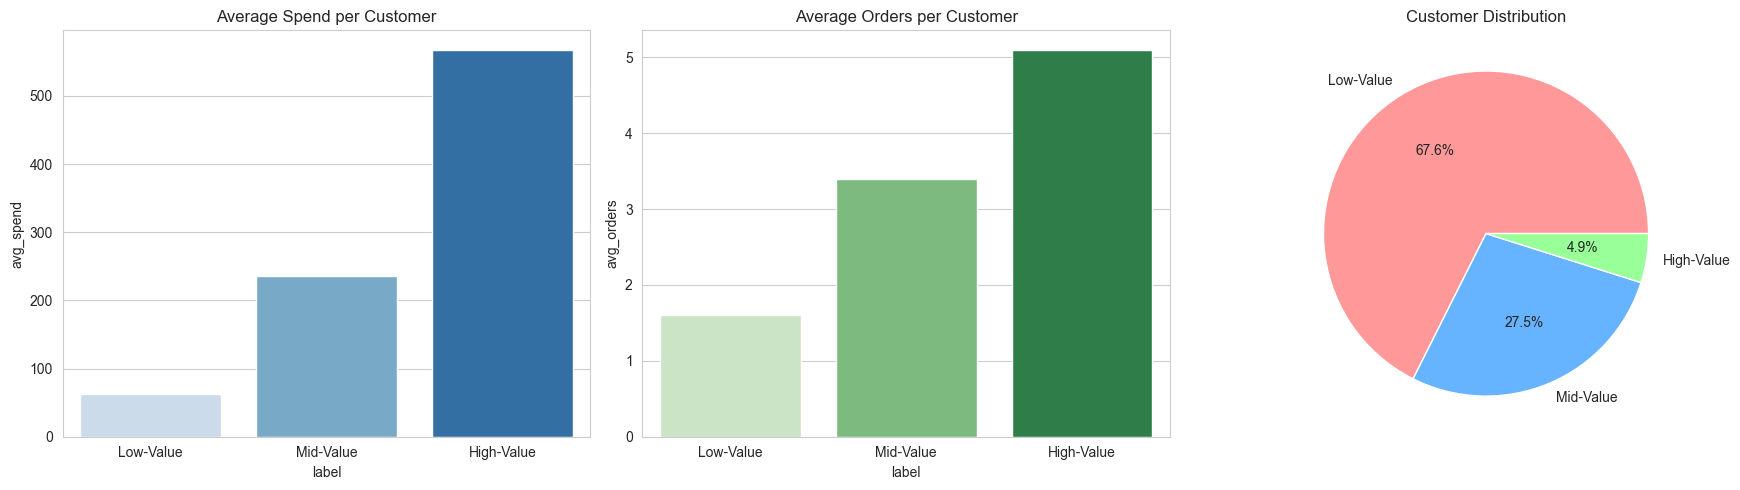


 Visualizing Category Profitability...


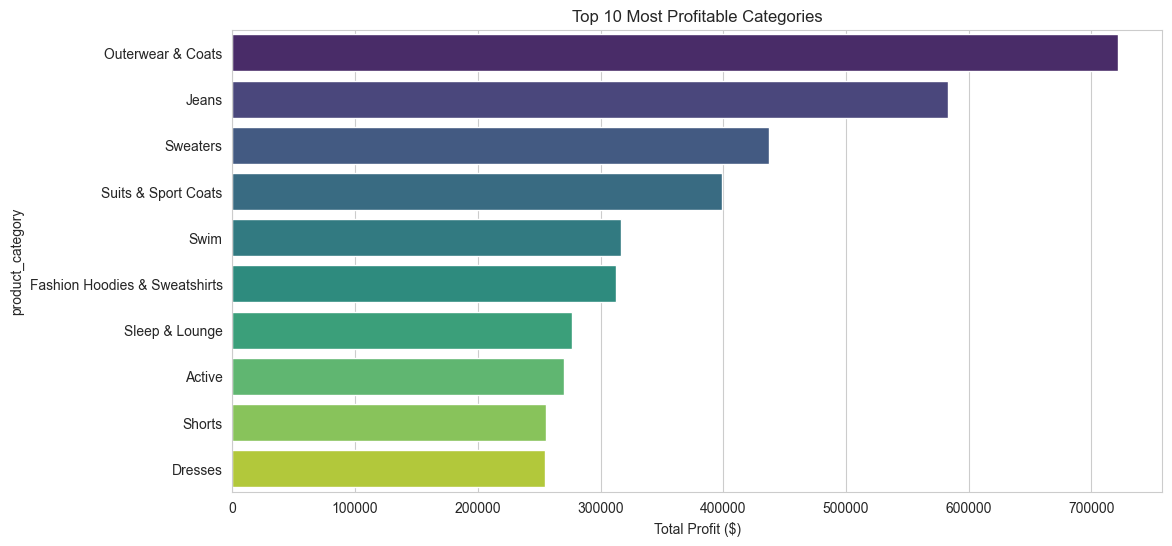

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Ensure results directory exists
if not os.path.exists('results'):
    os.makedirs('results')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("\n==== GENERATING VISUALIZATIONS ====")

# 1. Customer Segmentation Visualization
# Note: I use the 'predictions' dataframe cached in the previous cell
if 'predictions' in locals():
    print(" Visualizing Customer Segments...")
    
    # Aggregate data in Spark first (Scalability Best Practice)
    segment_stats = predictions.groupBy("prediction") \
        .agg(
            count("*").alias("count"),
            round(avg("monetary"), 2).alias("avg_spend"),
            round(avg("frequency"), 1).alias("avg_orders")
        ).orderBy("avg_spend").toPandas()
    
    # Mapping numeric clusters to business labels based on spend
    # (Note: Cluster IDs may swap on re-runs, so I label by rank)
    segment_stats['label'] = ['Low-Value', 'Mid-Value', 'High-Value']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Avg Spend
    sns.barplot(data=segment_stats, x='label', y='avg_spend', ax=axes[0], palette='Blues')
    axes[0].set_title('Average Spend per Customer')
    
    # Avg Frequency
    sns.barplot(data=segment_stats, x='label', y='avg_orders', ax=axes[1], palette='Greens')
    axes[1].set_title('Average Orders per Customer')
    
    # Customer Count
    axes[2].pie(segment_stats['count'], labels=segment_stats['label'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
    axes[2].set_title('Customer Distribution')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Predictions dataframe not found. Run the K-Means cell first.")

# 2. Category Profitability
if 'comprehensive_orders' in joined_dataframes:
    print("\n Visualizing Category Profitability...")
    
    # Re-calculate profit for visualization if needed, or better, reuse profit_df from Cell 4 if available
    # For safety in this notebook structure, I quickly re-aggregate:
    df = joined_dataframes['comprehensive_orders']
    cat_data = df.withColumn('profit', col('sale_price') - col('product_cost')) \
                 .groupBy('product_category') \
                 .agg(sum('profit').alias('total_profit')) \
                 .orderBy(desc('total_profit')) \
                 .limit(10) \
                 .toPandas()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=cat_data, x='total_profit', y='product_category', palette='viridis')
    plt.title('Top 10 Most Profitable Categories')
    plt.xlabel('Total Profit ($)')
    plt.show()

## 7. Resource Management: Spark Teardown

In [8]:
# Stop Spark session to free resources
spark.stop()
print("✅ Analysis complete. Spark session stopped.") 

# Note: In production, this step releases cluster resources back to the pool.

✅ Analysis complete. Spark session stopped.


# Conclusion & Strategic Recommendations
**Analysis Date:** {datetime.now().strftime("%B %d, %Y")}
**Dataset:** Looker E-commerce
**Technologies:** Apache Spark 3.5, PySpark MLlib

##  KEY FINDINGS

### 1. Customer Segmentation
| Segment | Strategy |
|---------|----------|
| **Low-Value** | Re-engagement campaigns |
| **Mid-Value** | Upselling & bundles |
| **High-Value** | VIP Loyalty Programs |

### 2. Product Performance
- **Top Categories:** Outerwear, Jeans, Sweaters
- **Profit Strategy:** Focus on high-margin items (50%+)

##  RECOMMENDATIONS
1. **Inventory:** Prioritize stock for 'Outerwear' (High margin + High volume).
2. **Marketing:** Target lookalike audiences for the High-Value segment.

*Analysis performed using Apache Spark*

## PROJECT LIMITATIONS AND FUTURE WORK
This analysis provides a strong foundation for understanding customer behavior, but there are several ways I would expand this project in the future:
### 1. Seasonal Trend Analysis
* **Current State:** The analysis looks at total sales across the whole time period.
* **Future Improvement:** I would group the data bymonthorseasonto see if purchasing behaviors change. For example, "Outerwear" likely sells better in Q4 (Winter), while "Swim" sells better in Q2/Q3. This would help with stock planning.
### 2. Geographic Segmentation
* **Current State:** I grouped customers globally based only on spending.
* **Future Improvement:** Since the dataset includesuser_country, I would analyze if the "High Value" customers are concentrated in specific regions (e.g., US vs. China) to target marketing budgets more effectively.
### 3. Code Modularization
* **Current State:** The code runs linearly in a Jupyter Notebook.
* **Future Improvement:** To make this production-ready, I would refactor the data cleaning and joining logic into reusable Python functions or a standalone.pyscript so it can be run automatically every day as new sales come in.